In [236]:
''' FUNCTIONS FOR EXTRACTION AND PROCESSING OF DATA WITH EMG RECORDINGS '''
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get list of files in specific directory with a specified extension (e.g. csv)
def get_files_in_directory(path, extension):
    os.chdir(path)
    result = glob.glob('*.{}'.format(extension))
    result.sort() # Ensure correct order of files
    return result

# Get list of numpy arrays, each corresp. to a csv file in list_files
def array_from_csv(list_files):
    if len(list_files) == 1:
        list_arr = pd.read_csv(list_files[0], sep=',', header=None).values
    else: 
        list_arr = [pd.read_csv(file, sep=',', header=None).values for file in list_files]
    return list_arr

# Shift an EMG recording
def shift(emg):
    avg = np.mean(emg)
    emg_shift_abs = np.abs([elem-avg for elem in emg])
    return emg_shift_abs

# Shift an EMG recording (1D array) to zero-mean level, take absolute value, and normalize wrt. maximum
def shift_abs_normalize_EMG(emg):
    avg = np.mean(emg)
    emg_shift_abs = np.abs([elem-avg for elem in emg])
    maximum = np.max(emg_shift_abs)
    return np.array([elem/maximum for elem in emg_shift_abs])

list_files = get_files_in_directory('/Users/danielluo/Desktop/BIOELECTRONICS/OutData/', 'csv')
list_datasets = array_from_csv(list_files)

# A) No flexion
# B) Full flexion, maximal force
# No flexion to:
#      C) Full flexion, minimal force
#      D) Full flexion, maximal force
#      E) Full extension, minimal force
#      F) Full extension, maximal force
#      G) Thumb direction flexion, minimal force
#      H) Thumb direction flexion, maximal force
#      I) Pinky finger flexion, minimal force
#      J) Pinky finger flexion, maximal force
# Part IV: Individual finger movements (prefix "F")
# K) Perpendicular
# L) Covering half the electrode and doing full flexion, maximal force
# M) Reference electrode on elbow
# N) Reference electrode on forehead
# O) Reference electrode right next to recording electrodes

In [273]:
'''Smoothing algorithms'''

import numpy as np
from math import factorial

# Savitzky-Golay smoothing uses polynomials
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Root-mean-square smoothing uses convolution with a square pulse
def window_rms(array, window_size):
    array_squared = np.power(array, 2)               # Square each element of array
    window = np.ones(window_size)/float(window_size) # Repr. square pulse whose width is the window size
    return np.sqrt(np.convolve(array_squared, window, 'valid'))

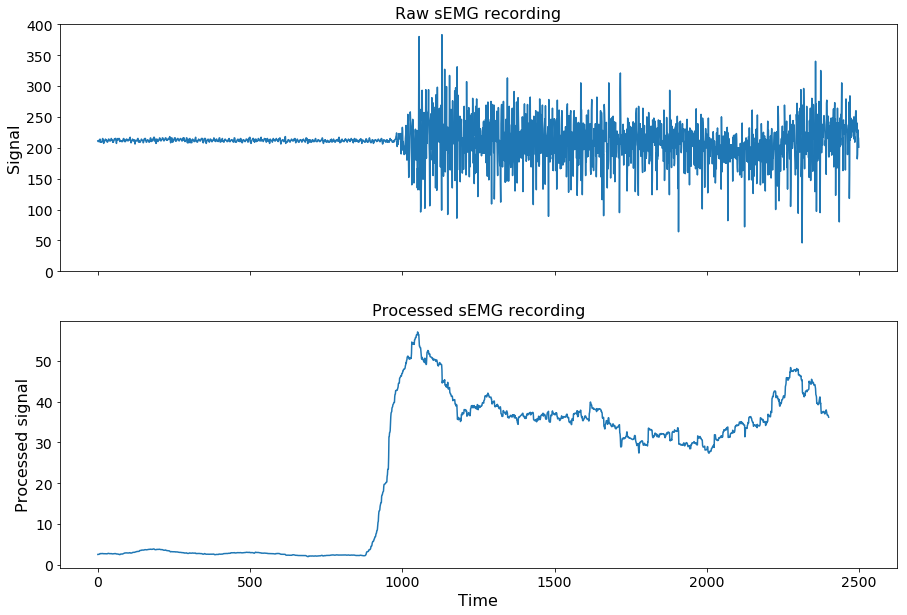

In [321]:
# EXAMPLE
#data[0][0][0] First index: dataset. Second index: time series. Third: which time step.

# Process a raw sEMG recording and plot both the raw and processed signals
def plot_sEMG(experiment, run, smoothing_algo = 'rms'):
    raw_semg = list_datasets[experiment][run] # [3][0] is a good example
    shifted_semg = shift(raw_semg)
    processed_semg = shift_abs_normalize_EMG(raw_semg)
    
    # Choose algorithm used for smoothening of sEMG signal
    if smoothing_algo == 'savitzky_golay':
        smooth_semg = savitzky_golay(shifted_semg, 101, 1)
    elif smoothing_algo == 'rms':
        smooth_semg = window_rms(shifted_semg, 100)

    f, axs = plt.subplots(2, sharex='col')
    axs[0].plot(raw_semg)
    axs[0].set_ylabel('Signal', fontsize=16)
    axs[0].set_title('Raw sEMG recording', fontsize=16)
    axs[0].tick_params(labelsize=14)
    axs[0].set_ylim(0, 400)
    #axs[0].set_xlim(900, 2500)
    
    axs[1].plot(smooth_semg)
    axs[1].set_ylabel('Processed signal', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=16)
    axs[1].set_title('Processed sEMG recording', fontsize=16)
    axs[1].tick_params(labelsize=14)
    #axs[1].set_ylim(0,200)
    #axs[0].set_xlim(900,2500)

    plt.rcParams['figure.figsize'] = [15, 10]
    plt.show()
    
    return None

plot_sEMG(3,0)

In [260]:
# The different experiments
expts_AO = list_files[:14]
expts_fingers = list_files[14:30]
expts_perp = list_files[-4:] # Last four elements

In [261]:
expts_perp

['Perpendicular a.csv',
 'Perpendicular b.csv',
 'Perpendicular c.csv',
 'Perpendicular d.csv']

In [294]:
'''Compute standard deviation or noise'''
sd = np.mean([np.std(elem) for elem in list_datasets[0]])
print(f"The standard deviation is: {sd}")

def signaltonoise(a):
    a = np.asanyarray(a)
    m = a.mean()
    sd = a.std()
    return np.where(sd == 0, 0, m/sd)

snr = signaltonoise(list_datasets[0][0])
print(f"The signal-to-noise ratio is: {snr}")



The standard deviation is: 1.5829877241646182
The signal-to-noise ratio is: 103.13818350488337
